# A joint multilevel model for CAR 
Using MVS.CARLeroux
## Common Markov Gaussian Random Field
 $$ [P , S ] = [P | GMRF] [ S | GMRF] $$

In [5]:
## Import code:
setwd('/apps/external_plugins/biospytial_rwrapper/biospytial.rwrapper/R/')

In [6]:
rm(list=ls())                                                                                     
source("init_data.R")                                                                             
# load the building function                                                                      
#source("joint.binomial.bymCAR.R")

S <- model.frame(formula_sample, DataFrame,na.action='na.pass')
P <- model.frame(formula_presence, DataFrame,,na.action='na.pass')

Loading required package: MASS
Loading required package: Rcpp

Attaching package: ‘dplyr’

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [70]:
SX <- select(S, -c(1))
PX <- select(P, -c(1))
Sy <- select(S, c(1))
Py <- select(P, c(1))

names(Sy) <- 'response'
names(Py) <- names(Sy)
Y = rbind(Sy,Py)

### Let's build covariance matrix
T1 <- matrix(rep(0,4), ncol = 2)
T2 <- matrix(rep(0,4), ncol = 2)
T1[1,1] <- 1
T2[2,2] <- 1

X <- data.frame((T1 %x% as.matrix(SX)) + (T2 %x% as.matrix(PX)))
names(X) <- c(names(SX),names(PX))

DD <- cbind(Y,X)

nK <- dim(M_bis)[1]
ida <- data.frame(seq(nK))
idarea <- unlist(rbind(ida,ida))

corx <- rep(x = 1,times = nK)
cory <- rep(x = 2,times = nK)

indre <- c(corx,cory)

formula <- response ~ Disttoroadm + Populationm + Elevationm + MeanTempm

In [72]:
## now, assuming that the order in M_bis is the same as in cellids (OOOORDEEER, not value)
## Run the model
trials = rep(1,2 * nK)
burnin = 29000
n.sample = 30000
thin = 1
model2 <- S.CARmultilevel(formula,family = 'binomial',
                          trials=trials, 
                          W=M_bis, 
                          ind.area = idarea,
                         ind.re=factor(idarea),
                          rho = 1,
                          burnin = burnin,
                          n.sample = n.sample,
                          data = DD
                         )

Setting up the model.
Generating 1000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  412 seconds.


In [32]:
### Notas
## El postburnin es una mamada, quitar

## Remember to check likelihood modelfit

In [73]:
model2$modelfit

DIC           p.d          WAIC           p.w          LMPL 
    3891.7765      969.7004     3980.7669      843.2110    -2063.0340 
loglikelihood 
    -976.1879

In [74]:
model2$summary.results

,Median,2.5%,97.5%,n.sample,% accept,n.effective,Geweke.diag
(Intercept),2.0596,1.6557,2.3602,1000,47.4,38.7,1.4
Disttoroadm,0.0002,0.0000,0.0003,1000,47.4,44.9,-1.3
Populationm,0.0004,0.0003,0.0006,1000,47.4,19.7,5.3
Elevationm,-0.0015,-0.0017,-0.0014,1000,47.4,27.5,-1.6
MeanTempm,-0.0028,-0.0031,-0.0025,1000,47.4,13.5,-1.9
tau2,10.0821,8.2641,15.1827,1000,100.0,2.3,5.3
sigma2,0.0044,0.0026,0.0061,1000,100.0,2.5,-6.8
rho,1.0000,1.0000,1.0000,NA,NA,NA,NA


## Some plots and analysis for convergence


In [75]:
library(coda)

## $\tau^{2}$

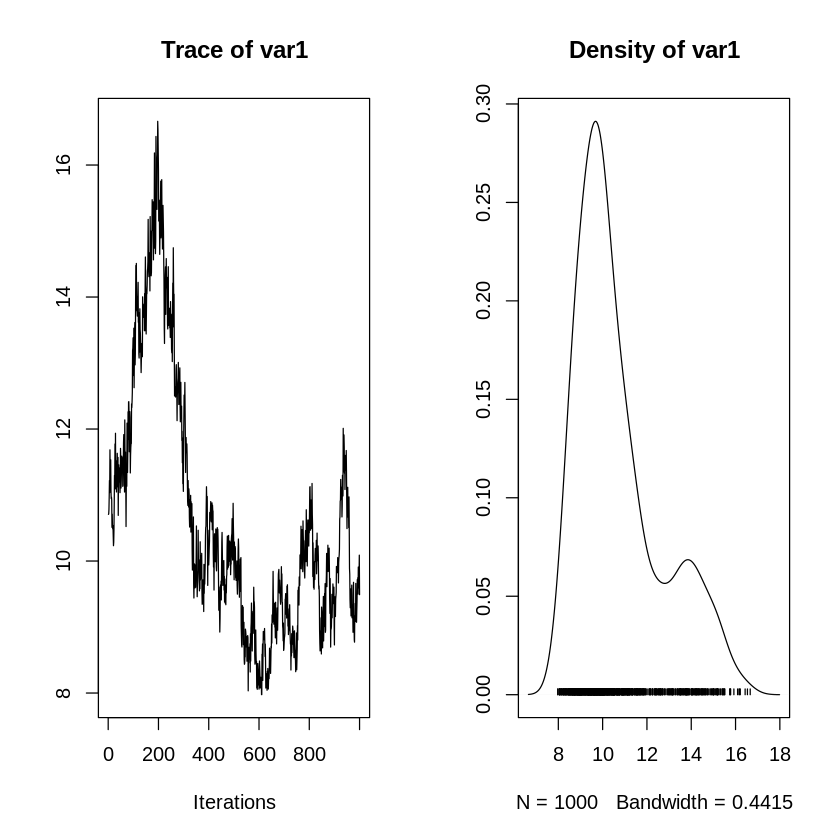

In [76]:
plot(model2$samples$tau2)
#plot(results$ind.model.S$model.results$samples$tau2)
#plot(results$ind.model.P$model.results$samples$tau2)

## $\sigma^2$

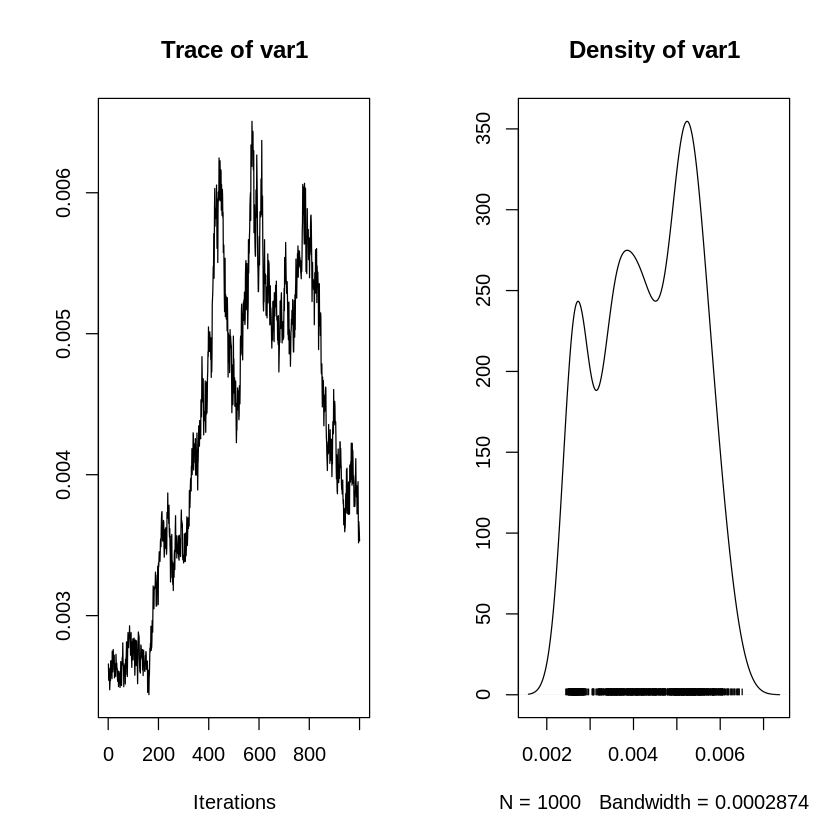

In [79]:
plot(model2$samples$sigma2)
#plot(results$ind.model.S$model.results$samples$sigma2)
#plot(results$ind.model.P$model.results$samples$sigma2)

## $\beta$

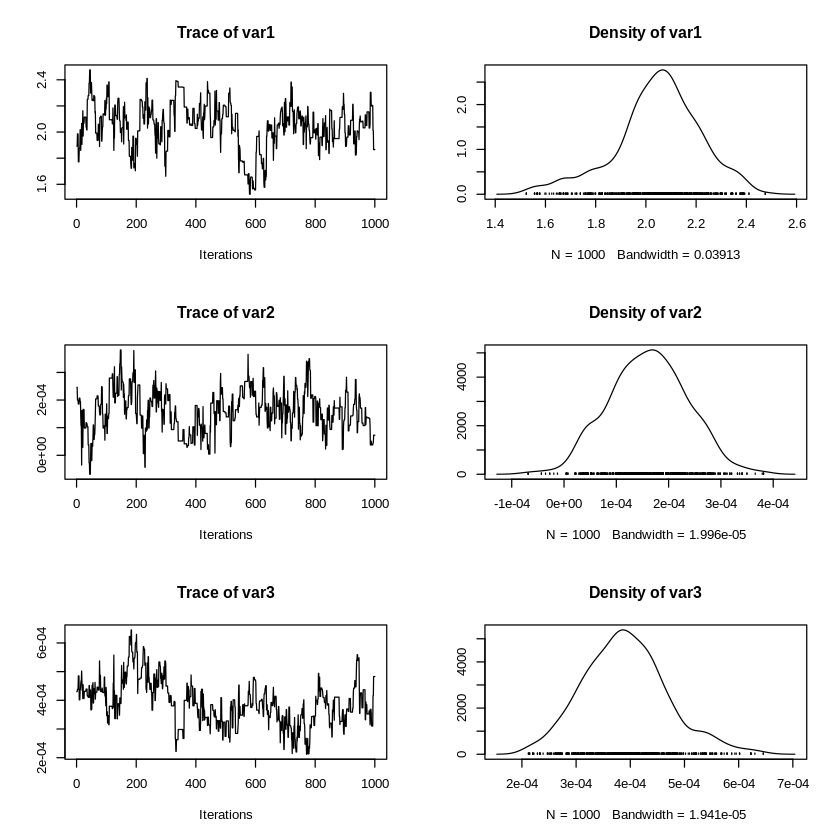

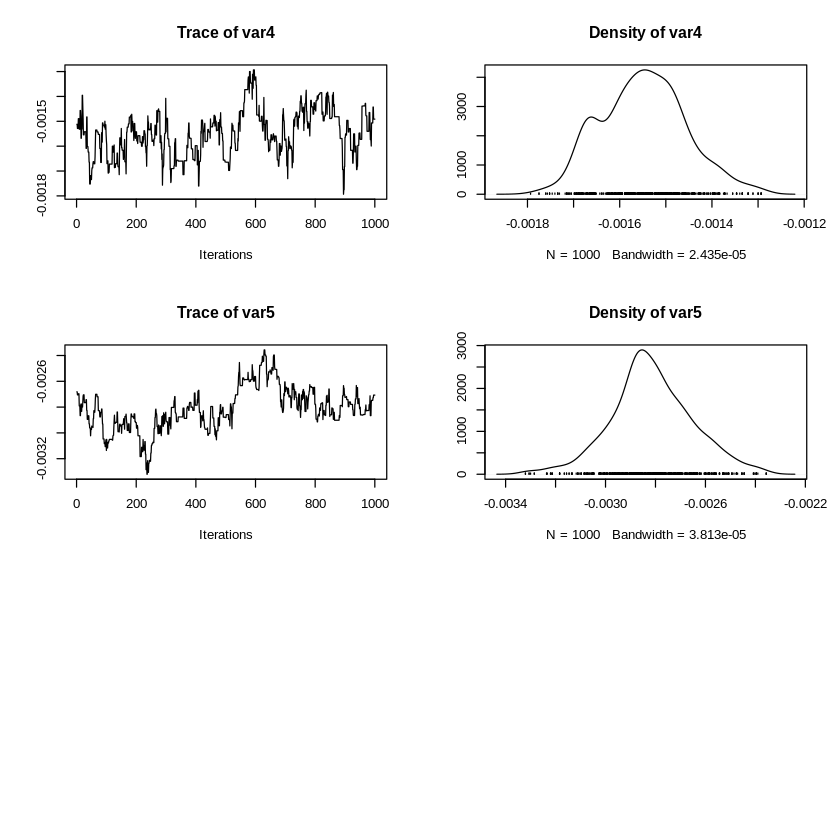

In [80]:
plot(model2$samples$beta)

#plot(results$ind.model.S$model.results$samples$tau2)
#plot(results$ind.model.P$model.results$samples$tau2)

### Extract and export Random Effects in the shape of raw sample

In [93]:

sample.re <- t(model2$samples$phi + model2$samples$zeta)
re.chain <- cbind(TDF$cellids,sample.re)
file2 <- '/outputs/presence_only_models/modelCAR_model2_randomeffect_multilevel.csv'
write.csv(re.chain,file2)

In [94]:
sample.re <- t(model2$samples$phi)
re.chain <- cbind(TDF$cellids,sample.re)
file2 <- '/outputs/presence_only_models/modelCAR_model2_phi_multilevel.csv'
write.csv(re.chain,file2)

In [95]:
sample.re <- t(model2$samples$zeta)
re.chain <- cbind(TDF$cellids,sample.re)
file2 <- '/outputs/presence_only_models/modelCAR_model2_zeta_multilevel.csv'
write.csv(re.chain,file2)

In [101]:
## P and S
## divide samples for S and P according to the order given up
fitted = model2$fitted.values
S <- fitted[1:nK]
P <- fitted[(nK +1) : (2*nK) ]
chain = cbind(TDF$cellids,S,P)
file_ = '/outputs/presence_only_models/modelCAR_model2_PS_multilevel.csv'
write.csv(chain,file_)


## Diagnostics, Mr. Gelmans, et.al

## Sample the posterior 

In [102]:
post.sample_p = data.frame(model2$samples$fitted)

In [84]:
pss  <- post.sample_p %>% mutate_all(function(p) rbernoulli(1,p))
                                        

In [141]:
## divide samples for S and P according to the order given up
pred.S <- pss[,1:nK]
pred.P <- pss[,(nK +1) : (2*nK) ]


In [142]:
sumpss <- colSums(pred.S)
nsample <- nrow(pred.S)
prob_pss <- sumpss / nsample

In [143]:
sumpps <- colSums(pred.P)
nsample <- nrow(pred.P)
prob_pps <- sumpps / nsample

In [144]:
probpres = prob_pps * prob_pss

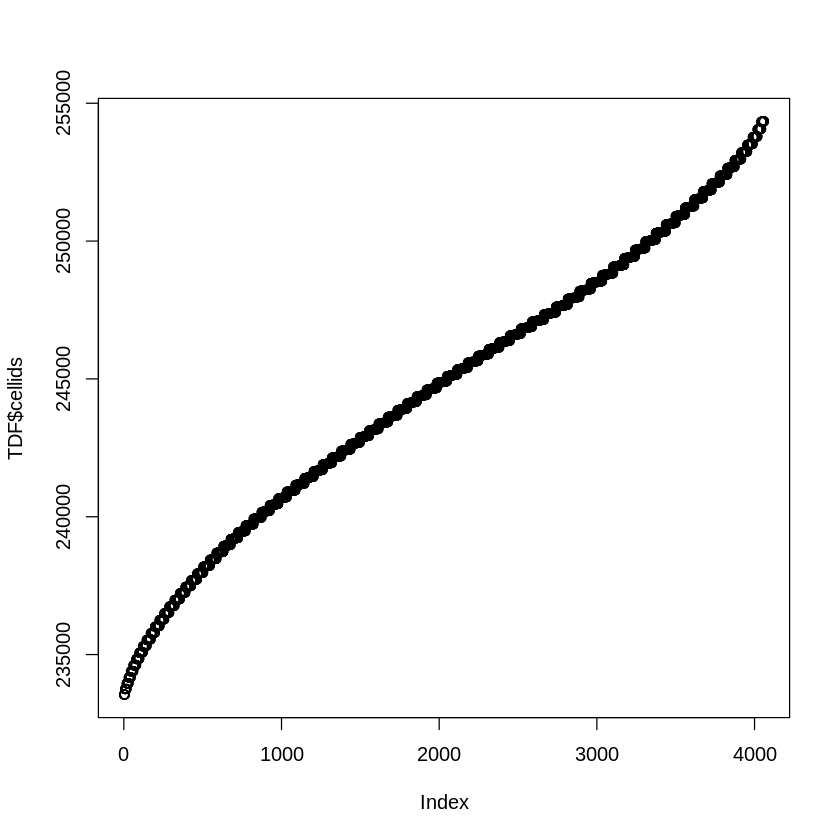

In [145]:
## plot TDF$cells to see if its order
plot(TDF$cellids)

In [146]:
chain = cbind(TDF$cellids,probpres,prob_pps,prob_pss)
file_ = '/outputs/presence_only_models/modelCAR_model2_fitted_multilevel.csv'
write.csv(chain,file_)

## Posterior análisis with a varying C $\tau^2, \sigma^2$ denominator

In [609]:
# Read the file
bfile = '/outputs/presence_only_models/joint-model2-benchmark-denominator.csv'
res <- read.csv(bfile)

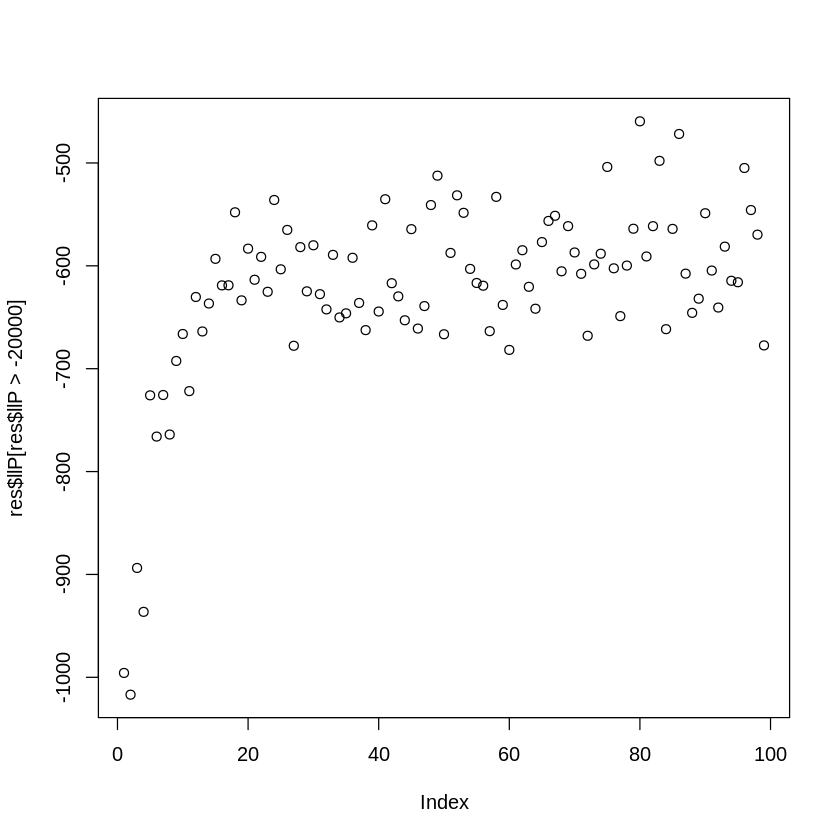